In [2]:
# Import necessary libraries, modules, etc.
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.cross_validation import cross_val_score # looks like this was deprecated

from sklearn.metrics import mean_squared_error

%matplotlib inline

/Users/warren/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [92]:
# I would like to use ggplot if possible

from ggplot import *

## Import Data

In [93]:
!pwd

/Users/warren/Data_Science/metis/not_github/projects/02_Luther


In [94]:
!ls luther_wtc/

luther_wtc                test_metacritic04_01.json test_metacritic05_02.json
scrapy.cfg                test_metacritic04_02.json test_metacritic05_03.json
test_metacritic01_01.json test_metacritic05_01.json test_metacritic05_04.json


In [95]:
with open('luther_wtc/test_metacritic05_02.json') as json_data:
    d = json.load(json_data)
    

In [96]:
colnames = ['movie', 'rel_date', 'rating', 'genres', 'runtime',
            'c_score', 'c_pos', 'c_mix', 'c_neg',
            'u_score', 'u_pos', 'u_mix', 'u_neg']

df1 = pd.DataFrame(d, columns = colnames)


## Clean Data

In [97]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7577 entries, 0 to 7576
Data columns (total 13 columns):
movie       7577 non-null object
rel_date    7577 non-null object
rating      7577 non-null object
genres      7577 non-null object
runtime     7446 non-null object
c_score     7575 non-null object
c_pos       6982 non-null object
c_mix       7235 non-null object
c_neg       5121 non-null object
u_score     6281 non-null object
u_pos       6234 non-null object
u_mix       5747 non-null object
u_neg       5736 non-null object
dtypes: object(13)
memory usage: 769.6+ KB


In [98]:
df1.head()

,movie,rel_date,rating,genres,runtime,c_score,c_pos,c_mix,c_neg,u_score,u_pos,u_mix,u_neg
0,Quiz Show,"September 14, 1994",PG-13,"Drama, History",133 min,88,13,None,None,8.7,84,2,4
1,Juwanna Mann,"June 21, 2002",PG-13,"Drama, Sport, Comedy, Romance",91 min,24,2,5,18,5.8,11,3,6
2,Oz the Great and Powerful,"March 8, 2013",PG,"Action, Adventure, Fantasy, Family",130 min,44,11,21,10,6.1,225,178,77
3,All the Wilderness,"February 20, 2015",Not Rated,Drama,85 min,54,4,7,None,None,None,None,None
4,Gypsy 83,"April 16, 2004",R,Drama,94 min,47,5,6,2,7.6,7,None,2


In [99]:
# Remove rows with null values in the following columns: runtime, c_score, u_score
df2 = (df1
       .dropna(subset = ['runtime', 'c_score', 'u_score'])
       .query('u_score != "tbd"')
       .assign(rel_date = lambda x: pd.to_datetime(x['rel_date']),
               u_pos = lambda x: x['u_pos'].str.replace(',', ''),
               u_mix = lambda x: x['u_mix'].str.replace(',', ''),
               u_neg = lambda x: x['u_neg'].str.replace(',', ''),
               runtime = lambda x: pd.to_numeric(x['runtime'].str.split(' ').str[0]).astype(int))
      .reset_index()
      .drop('index', axis = 1))

#rename runtime to runtime_min

In [100]:
# Change review cols to int
review_cols = list(df2.columns.values[5:])

df2[review_cols] = df2[review_cols].apply(pd.to_numeric).fillna(value = 0)

# Let's scale up the u_scores
df2['u_score'] = df2.u_score.apply(lambda x: x*10)

df2[review_cols] = df2[review_cols].astype(int)


In [101]:
df2.rating.value_counts()

R            2564
PG-13        1533
PG            678
Not Rated     677
Unrated       218
G             116
TV-MA          83
NC-17          48
TV-14          21
TV-PG          14
Approved       11
TV-G           10
X               6
Open            6
M               5
GP              4
Passed          3
PG--13          2
TV-Y7           1
Name: rating, dtype: int64

In [102]:
# Change 'Not Rated' to 'Unrated', 'TV-G' to 'G', 'TV-PG' to 'PG', 'GP' to 'PG', 'PG--13' to 'PG-13'
#
dict_rating = {'Not Rated' : 'Unrated', 'TV-MA' : 'R', 'TV-14' : 'PG-13', 'TV-PG' : 'PG', 'TV-G' : 'G',
              'GP' : 'PG', 'PG--13' : 'PG-13', 'TV-Y7' : 'PG'}

ratings_keep = ['G', 'PG', 'PG-13', 'R', 'Unrated']

df3 = (df2
       .replace({'rating' : dict_rating})
       .query('rating in ["G", "PG", "PG-13", "R", "Unrated"]')) # how to make this better?

In [103]:
df3.rating.value_counts()

R          2647
PG-13      1556
Unrated     895
PG          697
G           126
Name: rating, dtype: int64

In [104]:
# Filter out movies that don't have a modeled rating.
# This will filter out some movies that are mislabeled, e.g. Requiem for a Dream (rating labeled as "Open").
# Movies with ratings like NC-17 were also excluded from the investigation.

In [105]:
df3.head()

,movie,rel_date,rating,genres,runtime,c_score,c_pos,c_mix,c_neg,u_score,u_pos,u_mix,u_neg
0,Quiz Show,1994-09-14,PG-13,"Drama, History",133,88,13,0,0,87,84,2,4
1,Juwanna Mann,2002-06-21,PG-13,"Drama, Sport, Comedy, Romance",91,24,2,5,18,58,11,3,6
2,Oz the Great and Powerful,2013-03-08,PG,"Action, Adventure, Fantasy, Family",130,44,11,21,10,61,225,178,77
3,Gypsy 83,2004-04-16,R,Drama,94,47,5,6,2,76,7,0,2
4,Eyes Without a Face [re-release],2003-10-31,Unrated,"Drama, Mystery, Thriller, Horror",88,90,8,1,0,88,21,0,1


## Clean Data - Fix Genres

In [106]:
# Use a set instead of a list?
# Clean genres? It includes both 'music' and 'musical'
genres_list = []

for genre in df3.genres.unique():
    for g in genre.split(', '):
        if g not in genres_list:
            genres_list.append(g)

genres_list.remove('')

In [107]:
genre_bool_dict = {genre : [genre in movie for movie in df2.genres] for genre in genres_list}

genre_bool_df = pd.DataFrame.from_dict(genre_bool_dict)


In [108]:
df4 = df3.join(genre_bool_df)#.drop('genres')

#df3[['movie', 'c_score', 'u_score']]

In [109]:
# how to make 'unrated' the base level?

df_rating = patsy.dmatrix('rating', data = df4, return_type = 'dataframe')

df5 = df4.join(df_rating)

In [110]:
new_colnames = {col : col.replace('[T.', '_').replace(']', '').replace('-', '_') for col in df5.columns.values}

df5 = df5.rename(columns = new_colnames)

## Engineer Features

In [172]:
# c_spread and c_num
df6 = (df5.assign(c_score2 = (df5['c_pos'] - df5['c_neg'])/(df5['c_pos'] + df5['c_neg']),
                  c_num = df5['c_pos'] + df5['c_mix'] + df5['c_neg']))

df6 = (df6.assign(c_spread = np.sqrt(df5['c_pos']*(1 - df6['c_score2'])**2 + 
                              df5['c_mix']*(0 - df6['c_score2'])**2 + 
                              df5['c_neg']*(-1 - df6['c_score2'])**2)/df6['c_num'],
                 review_diff = df5['u_score'] - df5['c_score']))

## Pickle Data

In [173]:
df6.to_pickle('data_metacritic_cleaned2.pkl')

In [39]:
df_omdb = pd.read_pickle('data_omdb.pkl')

In [165]:
df_omdb2 = (df_omdb
            .query('Gross != "N/A"')
            .assign(Gross = pd.to_numeric(df_omdb2['Gross'].str.replace(',','').str.replace('$',''))))

df_omdb2.columns = ['movie', 'year', 'gross']

In [174]:
cols = list(df6.columns.values)
keepcols = cols[0:2] + cols[-2:] + cols[4:5] + cols[6:9] + cols[13:-2]

df_metacritic = (df6
                 [keepcols]
                 .assign(year = df6['rel_date'].dt.year,
                         movie = df6['movie'].str.replace('re-release]', '').str.replace('[', '')))
                 #.rename({'movie' : 'Movie', 'year' : 'Year'})) # This wasn't working for some reason

In [127]:
#list(set(df_metacritic.columns.values) & set(df_omdb2.columns.values))

['movie', 'year']

In [4]:
df_join = df_omdb2.merge(df_metacritic, how = 'left', on = ['movie', 'year'])

NameError: name 'df_omdb2' is not defined

In [324]:
df_join.describe().loc[['min', 'max']].T.sort_values('min')
# Normalize runtime, gross, year

,min,max
review_diff,-61.0,7.300000e+01
c_score2,-1.0,1.000000e+00
c_spread,0.0,4.330127e-01
c_pos,0.0,5.100000e+01
c_mix,0.0,3.200000e+01
c_neg,0.0,2.700000e+01
rating_PG,0.0,1.000000e+00
rating_PG_13,0.0,1.000000e+00
rating_R,0.0,1.000000e+00
rating_Unrated,0.0,1.000000e+00


In [325]:
# Get averages and stddevs for runtime, gross, year
means_stds = df_join.describe().loc[['mean', 'std'], ['runtime', 'gross', 'year']]
means_stds

,runtime,gross,year
mean,106.520996,4.724032e+07,2008.463768
std,17.632700,7.067365e+07,4.734561


In [326]:
# Actually, let's normalize year differently
year_stuff = df_join.describe().loc[['min', 'max'], ['year']]
year_stuff

,year
min,1980.0
max,2017.0


In [327]:
df_join = (df_join
          .assign(runtime = (df_join['runtime'] - 106.52)/17.63,
                  gross = (df_join['gross'] - 47240320)/70673650,
                  year = (df_join['year'] - 1980)/(2017 - 1980)))

df_join.describe().loc[['mean', 'std', 'min', 'max'], ['runtime', 'gross', 'year']]

,runtime,gross,year
mean,0.000056,-2.855674e-08,0.769291
std,1.000153,1.000000e+00,0.127961
min,-3.773114,-6.684236e-01,0.000000
max,6.380034,9.939485e+00,1.000000


## Inspect Data

In [328]:
def find_corrs(df, cols, threshold, prec = 2):
    df_corr = df[cols].corr()
    
    list_corr = []
    
    for i in range(df_corr.shape[0]):
        for j in range(df_corr.shape[1]):
            correl = df_corr.iloc[i, j]
            if i > j and abs(correl) > threshold:
                row = df_corr.index[i]
                col = df_corr.index[j]
                list_corr.append((row, col, round(correl, prec))) # The rounding seems odd (see results)

    return list_corr

features = list(df_join.columns.values).copy()

find_corrs(df_join, features, threshold = 0.5)
    

[('c_pos', 'c_spread', -0.69999999999999996),
 ('c_pos', 'review_diff', -0.53000000000000003),
 ('c_neg', 'c_pos', -0.66000000000000003),
 ('Family', 'Animation', 0.56999999999999995),
 ('Musical', 'Music', 0.56000000000000005),
 ('rating_PG', 'Family', 0.66000000000000003),
 ('rating_R', 'rating_PG_13', -0.60999999999999999),
 ('c_num', 'c_spread', -0.64000000000000001),
 ('c_num', 'c_pos', 0.66000000000000003),
 ('c_score2', 'review_diff', -0.51000000000000001),
 ('c_score2', 'c_pos', 0.81000000000000005),
 ('c_score2', 'c_neg', -0.84999999999999998)]

In [177]:
len(df_join.columns.values)

42

In [329]:
df_corr = df_join.corr()
df_corr.iloc[3].sort_values()

c_pos            -0.534333
c_score2         -0.510994
c_num            -0.229557
year             -0.223468
Documentary      -0.172023
Biography        -0.112785
rating_Unrated   -0.101695
Drama            -0.098915
History          -0.086238
runtime          -0.080457
News             -0.063684
gross            -0.055859
rating_R         -0.047583
Animation        -0.040893
War              -0.039038
Adult            -0.037554
Music            -0.025839
Short            -0.018656
Musical          -0.002636
Family           -0.000591
Adventure         0.004152
Sci_Fi            0.008916
Western           0.009912
Fantasy           0.015346
rating_PG         0.021173
Sport             0.048477
Mystery           0.055642
Crime             0.066300
Romance           0.071720
Comedy            0.088292
Thriller          0.095511
rating_PG_13      0.099586
Horror            0.100687
Action            0.101998
c_mix             0.258329
c_spread          0.397963
c_neg             0.454129
r

In [330]:
nulls = df_join.isnull().any(axis = 1)

nulls2 = nulls[nulls].index.values

df_join.drop(nulls2, inplace = True)


NameError: name 'df_join' is not defined

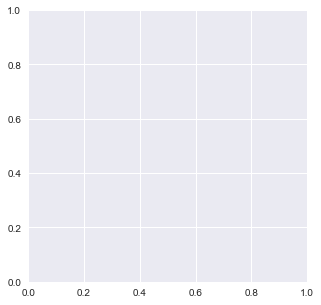

In [3]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(5,5)

ax.hist(df_join.review_diff, label='review_diff')

#ax.yticks(np.arange(0, 120, 20)) # AttributeError: 'AxesSubplot' object has no attribute 'yticks'
#ax.set_ylim((0, 110))
#ax.set_xlim((0, 110))
ax.set_xlabel('Review Differential')
ax.set_ylabel('Count')
ax.set_title('Histogram of "Review Differential"')

## Simple Linear Regression

In [273]:
# Simple linear regression of u_score vs c_score
lm1 = smf.ols('review_diff ~ c_spread', 
              data = df_join)

fit1 = lm1.fit()

fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            review_diff   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     505.4
Date:                Wed, 19 Apr 2017   Prob (F-statistic):          1.05e-102
Time:                        19:02:19   Log-Likelihood:                -10924.
No. Observations:                2688   AIC:                         2.185e+04
Df Residuals:                    2686   BIC:                         2.186e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9267      0.713     -4.105      0.000      -4.325      -1.529
c_spread     126.2252      5.614     22.482      0.000     115.216     137.234
==============================================================================
Omnibus:                       84.971   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.191
Skew:                           0.192   Prob(JB):                     2.02e-39
Kurtosis:                       4.202   Cond. No.                         20.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model Selection

In [254]:
# Split data into predictors (X) and target (y)
X = df_join.drop(df_join.columns[[0, 3, 5, 7, 8, 9, -2, -1]], axis = 1)
y = df_join['review_diff']


In [255]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [256]:
# Create KFold indices
kf = KFold(n_splits=5, shuffle=True)

In [261]:
# Do the Lasso
# Could use LassoCV as well!

all_scores={}
alphas=[1e-7,1e-5,1e-3,1e-1,1,100]

for a in alphas:
    est=Lasso(alpha=a)
    
    mse_alpha = 0
        
    for train, test in kf.split(X_train):
        x_tr=X_train.iloc[train]
        y_tr=y_train.iloc[train]

        x_te=X_train.iloc[test]
        y_te=y_train.iloc[test]

        est.fit(x_tr,y_tr)
        mse=np.mean((y_te-est.predict(x_te))**2)

        mse_alpha += mse
    
    all_scores[a] = mse_alpha

print(all_scores)

{1e-07: 917.340348888327, 1e-05: 920.3231140310698, 0.001: 924.8073007169327, 0.1: 945.6258895059318, 1: 1134.1468280655324, 100: 1198.9734172708113}


/Users/warren/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


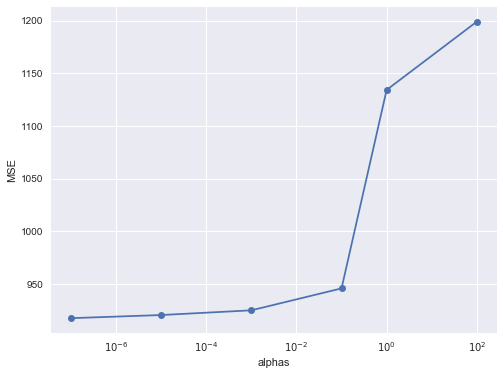

In [262]:
# Which alpha is the best for our model ? Looks like alpha= 0
f = plt.figure(figsize=(8,6))
#plt.ylim(0,0.1)

# for a in alphas:
#     plt.bar(all_scores[a],label = 'cv %s'%a)
plt.semilogx(list(all_scores.keys()), list(all_scores.values()),marker='o')
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')

In [267]:
# Do the Lasso for the optimal alpha/lambda value
final_alpha = 1e-3

est = Lasso(alpha = final_alpha)

est.fit(X,y)

mse=np.mean((y-est.predict(X))**2)

print(list(zip(X.columns.values, est.coef_)))
print(est.intercept_)
# Evaluate the model against the testing data
print('Test:', est.score(X_test, y_test))

[('year', -0.62887473288368678), ('gross', -1.1106179716230617e-08), ('c_spread', 114.57488041927147), ('runtime', 0.012282844656215439), ('Action', 3.0412297948005906), ('Adult', -16.739781239315313), ('Adventure', -0.063398679906346969), ('Animation', -1.8746062820900646), ('Biography', -0.18137070531010854), ('Comedy', 1.7434861010900049), ('Crime', 1.9477458585315817), ('Documentary', -4.6757517359831917), ('Drama', -2.2863213431121179), ('Family', 0.41831216518514291), ('Fantasy', 0.14672731993844373), ('Film_Noir', 0.0), ('History', -0.91685997769114025), ('Horror', 2.7183514208227235), ('Music', -1.2013579713702449), ('Musical', 1.2448995549175248), ('Mystery', 2.0513970113649798), ('News', -1.8242212711096195), ('Romance', 2.2963978324904861), ('Sci_Fi', -0.96166482497807004), ('Short', -2.9485791420102192), ('Sport', 2.6631292553634567), ('Thriller', 0.6122347186136895), ('War', -0.82780648044203897), ('Western', 1.6201114306511335), ('Intercept', 0.0), ('rating_PG', 3.3441634

In [269]:
rcv = RidgeCV(cv=5)

rcv.fit(X_train, y_train)
rcv.score(X_test, y_test)

0.2458217182200623

In [272]:
lcv = LassoCV(cv = 5)

lcv.fit(X_train, y_train)
lcv.score(X_test, y_test)

0.006270218425264984